# License Plate Recognition using Machine Learning

*by Tanjim Bin Faruk, December 12, 2022* 

## 💻 Introduction

When it was time to submit an idea for the CS 545 term project, I had watched [a video on YouTube](https://www.youtube.com/watch?v=4AnyhHl3_tE) around that time. It was about Dashcam footage quality. The video went on to describe how the video quality of every dashcam is subpar, no matter what the cost. It piqued my interest and I decided why not build something that can possibly detect license plate number from dashcam footage.

I searched around and found an interesting dataset on Kaggle. I also heard about object detection models in the passing during my undergrad, specifically YOLO models. I decided to use them for this project.

I was initially eager to use the CNN model that we built for Assignment $5$, but decided not to go down that path as the accuracy for that model was not that great. I focused on OCRs instead.

## ⚙️ Methods
  

### 📂 Dataset

I downloaded a public domain dataset from Kaggle [Maranhão, 2019]. The dataset contains $433$ images of license plate, which on the first look, appear to be from a number of different countries. The dataset contained two folders: *Images* and *Annotations*. The *Images* folder contained the *".jpg"* files for license plates. For each of the JPG files in the *Images* folder, the *Annotation* folder contained an "*.xml"* file. The XML files contained the bounding box coordinates of the license plate in the images.


### 🪛 License Plate Detection Algorithm

I decided to use YOLOv5 [Jocher, et al., 2020] which is an acronym for 'You only look once'. YOLO is one of the most famous object detection algorithms due to its speed and accuracy. It is a state of the art object detection algorithm that divides images into a grid system. It is a pre-trained model trained on the [MS COCO](https://cocodataset.org/#home) dataset, which includes $80$ categories of object. As the categories of objects did not include license plates, I needed to retrain the model on a custom license plate dataset. As YOLOv5 is a pre-trained model, using transfer learning, it would converge much faster and would have much better accuracy than say a CNN model written from scratch. Using a scratch CNN model would result in a lot of time spent for fine tuning the parametes to arrive at a satisfactory result.

### 📥 Data Preprocessing

In order to pass my dataset to the YOLOv5 model, I needed to restructure the folder hierarchy for *Images* and *Annotations*. Following [Train Custom Data on YOLOv5](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data), I first needed to create a `dataset.yaml` file which would contain the directory path for train, validation and test folders as well as key-value pair(s) for each of the classes. As we are only detecting license plates, our `dataset.yaml` would contain only one key-value pair.

YOLOv5 requires a label for each images in the form a text document. As our downloaded dataset contains the annotations in XML files, I extracted the bounding box information from XML files and put them in a `labels` directory beside `images` folder.

### 📀 Train-Validation-Test Split

After restructuring the folders, I partitioned the whole dataset into train, validation and test sets. Initial $80\%$ data was earmarked for train set. The remaining $20\%$ was split evenly between the validation and test set.

### 📲 YOLOv5 Training

To train the model, we need to run the `train.py` file inside `yolov5` directory. There are a number of parameters to specify:

```python
!cd yolov5-license-plate && python train.py --batch 16 --epochs 50 --data dataset.yml --weights yolov5s.pt --workers 2
```

- ***Batch size***: I specified the batch size to be $16$. Increasing the batch size to $64$ resulted in exhausting my GPU memory and halting the training process.
- ***Epochs***: I decided to go with $50$ epochs as there were quite a few files to be trained on. I assume increasing the number of epochs would lead to a better performance, but there could be diminishing returns.
- ***Weights***: There are $4$ models to choose from: `yolo5s` (small), `yolov5m` (medium), `yolov5l` (large) and `yolov5x` (extra large). The size and complexity of these models increases in the ascending order. As my workflow did not require complex setup, I chose `yolov5s`.
- ***Workers***: Number of CPU workers. I specified it to be $2$.

Apart from these parameters, there are two other important files. One is used for the specifying the model architecture and the other can be used to fine tune the hyper-parameters.

Under `yolov5 > models` directory, the `yolov5s.yaml` contains the following architecture:

```yaml
# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

```

Inside the YAML file, $3$ subdivisions are noticed: Anchors, Backbone, and Head. According to [Anchor Boxes for Object Detection](https://www.mathworks.com/help/vision/ug/anchor-boxes-for-object-detection.html):

> Anchor boxes are a set of predefined bounding boxes of a certain height and width. These boxes are defined to capture the scale and aspect ratio of specific object classes you want to detect and are typically chosen based on object sizes in your training datasets.

The Backbone part mainly consists of Convolutional Neural Network, C3 (Concentrated-Comprehensive Convolution), and SPPF (Spatial Pixel Pair Features) modules for feature extraction. The Head network performs target prediction and passes the predicted output. 

Under `yolov5 > data > hyps` directory, `hyp.scratch-med.yaml` contains the following:

```yaml
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.3  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 0.7  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.9  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.1  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)
```

The hyperparameter config file contains quite a few important fields such as:

- Learning Rate
- Momentum
- Weight Decay
- Parameters for Box Loss (Mean Squared Error), Objective Loss (Binary Cross Entropy) and Class Loss (Cross Entropy)
- Hue, Saturation, Value parameters
- Scale, Rotation and Translation parameters


### 📑 Text Extraction

Given a picture, our trained YOLOv5 model narrows down to a region of interest (ROI) that likely contains the license plate. I thought of two ways to extract the text: one with Segmented Characters and the other with Whole Image.

#### 📥 Image Preprocessing

Before passing the image through an OCR, I preprocessed the image. First I converted the image to Grayscale. Then, I passed it through a Bilateral Filter to reduce the noise. I also inverted the image and applied thresholding to have white text on black background.

#### 📋 Optical Character Recognition (OCR)

In order to obtain the license plate number as text, I employed OCR techniques. I decided to use `easyocr` module for this, which is a lightweight and efficient OCR. I also played around with `pytesseract`, but found EasyOCR's performance much better.

#### 📷 Character Segmentation with Contour Detection

After finding a ROI from YOLOv5 model, I passed the ROI through EasyOCR for a first pass, to focus on a large block of text in the middle of the image. The result was that it further narrowed down the initial ROI. After that, I did contour detection to extract individual characters as images. Finally, I did a second pass through EasyOCR on these images to figure out the character and concatenate them.

#### 💡Whole Image Detection

Unlike character segmentation, I only did one single pass to extract the text.

## 🚩 Results

The information for each training is saved under `yolov5 > runs > train > exp` directory. After the training was completed, a bunch of graphs were generated and by looking at them I could tell that the model training went well.

### 📌 Precision-Recall Curve

According to [Precision-Recall Curves by Doug Steen](https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248), the performance of PR curves can be compared in the following way:

[<img alt = "PR Curve Performance" src="https://miro.medium.com/max/720/1*6QPLsDvjo4H6OZrxEBI8Fg.webp">]

The following graph shows that our trained model nearly reached the perfect classifier performance.

[<img alt = "Precision-Recall Curve" src="yolov5-license-plate/runs/train/exp/PR_curve.png" width = 1000/>](yolov5-license-plate/runs/train/exp/PR_curve.png)

### 📌 F1 Curve

Our model achieved a higher F1 score (closer to 1), which correlates to better performance.

[<img alt = "F1 Curve" src="yolov5-license-plate/runs/train/exp/F1_curve.png" width = 1000/>](yolov5-license-plate/runs/train/exp/PR_curve.png)

### 📌 Metrics

The following graph shows that the `box_loss` and `obj_loss` decreased with each iteration. The `cls_loss` is $0$ because there is no misclassification (as there is only one class).

[<img alt = "F1 Curve" src="yolov5-license-plate/runs/train/exp/results.png" width = 1000/>](yolov5-license-plate/runs/train/exp/results.png)

### 📌 Prediction Results

Let's take an example image from the test set.

[<img alt = "Test Image" src="sample-test-car.png">](sample-test-car.png)

The model successfully narrowed down to the ROI.

[<img alt = "Test Image" src="roi-sample.jpg">](roi-sample.jpg)

The OCR then further narrowed down the initial ROI.

[<img alt = "Test Image" src="narrowed-down-roi-sample.jpg">](narrowed-down-roi-sample.jpg)

Which is quite hard to see so let's use Matplotlib.

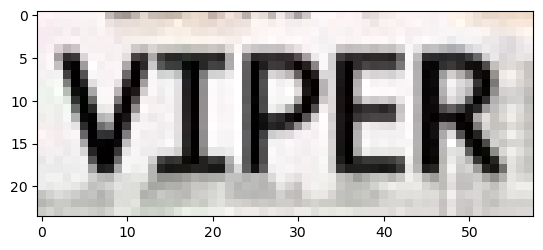

In [1]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

_image = cv2.imread(os.path.join('narrowed-down-roi-sample.jpg'))
plt.imshow(_image, cmap='gray')

Finally, passing this image to OCR extracts the license plate number as text (***VIPER*** in this case) which is saved to a CSV file.

## 🔖 Conclusions

Before starting this project, I had only a vague idea about object detection models. I learned a great deal about object detection models and OCR in general. Preparing the data in the required format to pass it to the YOLOv5 model was another learning experience.

The most difficult part was surprisingly the text extraction. Initially, I was under the impression that narrowing down to the license plate region would be hard and subsequent text extraction would be easy. It turned out to be exactly the opposite. I had play around quite a while to figure out how to extract the text. I tried a bunch of approaches:

- Train a CNN on EMNIST dataset. It did not work out as expected possibly because the EMNIST dataset is mostly handwritten data but license plate characters are not.
- Image Preprocessing was another difficult task. I had to tune the parameters in such a way so that the preprocessed image would be suitable for contour detection.
- Detecting the contours took a long time. Primarily because I had to figure out how to focus on the core area on the license plate, ignoring all other contour noises.
- Finally, even though the preprocessed segmented characters were quite legible, OCRs had a tough time recognizing them. I am not sure why but maybe a CNN would be better fitted for this task. I ran out of time for experiments but plan tweak this in the future.

###  📖 References

* [Jocher, et al., 2020] Glenn Jocher; Ayush Chaurasia; Alex Stoken; Jirka Borovec; NanoCode012; Yonghye Kwon; Kalen Michael; TaoXie; Jiacong Fang; imyhxy; Lorna; 曾逸夫(Zeng Yifu); Colin Wong; Abhiram V; Diego Montes; Zhiqiang Wang; Cristi Fati; Jebastin Nadar; Laughing; UnglvKitDe; Victor Sonck; tkianai; yxNONG; Piotr Skalski; Adam Hogan; Dhruv Nair; Max Strobel; Mrinal Jain, [YOLOv5 SOTA Realtime Instance Segmentation](https://github.com/ultralytics/yolov5), Zenodo, 2020

In [1]:
import io
import nbformat
import glob
nbfile = glob.glob('Faruk-Project-Report.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Faruk-Project-Report.ipynb is 2146


In [2]:
import os

IMAGES_PATH = os.path.join('data', 'images')
ANNOTATIONS_PATH = os.path.join('data', 'annotations')
TRAIN_FOLDER = os.path.join('data', 'train')
VALIDATION_FOLDER = os.path.join('data', 'validation')
TEST_FOLDER = os.path.join('data', 'test')

In [ ]:
if not os.path.exists(TRAIN_FOLDER):
    os.makedirs(TRAIN_FOLDER)

if not os.path.exists(VALIDATION_FOLDER):
    os.makedirs(VALIDATION_FOLDER)

if not os.path.exists(TEST_FOLDER):
    os.makedirs(TEST_FOLDER)

if not os.path.exists(f'{TRAIN_FOLDER}\images'):
    os.makedirs(f'{TRAIN_FOLDER}\images')

if not os.path.exists(f'{TRAIN_FOLDER}\labels'):
    os.makedirs(f'{TRAIN_FOLDER}\labels')

if not os.path.exists(f'{VALIDATION_FOLDER}\images'):
    os.makedirs(f'{VALIDATION_FOLDER}\images')

if not os.path.exists(f'{VALIDATION_FOLDER}\labels'):
    os.makedirs(f'{VALIDATION_FOLDER}\labels')

if not os.path.exists(os.path.join(TEST_FOLDER, 'images')):
    os.makedirs(os.path.join(TEST_FOLDER, 'images'))

if not os.path.exists(os.path.join(TEST_FOLDER, 'labels')):
    os.makedirs(os.path.join(TEST_FOLDER, 'labels'))

In [ ]:
import kaggle

In [ ]:
!cd data & kaggle datasets download -d andrewmvd/car-plate-detection

In [ ]:
import shutil

zipped_file = os.path.join('data', 'car-plate-detection.zip')

shutil.unpack_archive(zipped_file, os.path.join('data'))
os.remove(zipped_file)

In [ ]:
labels_dict = {'licence': 0}

In [ ]:
image_files = [f for f in os.listdir(IMAGES_PATH) if os.path.isfile(f'{IMAGES_PATH}\{f}')]
annotation_files = [f for f in os.listdir(ANNOTATIONS_PATH) if os.path.isfile(f'{ANNOTATIONS_PATH}\{f}')]

In [ ]:
from sklearn.model_selection import train_test_split

image_files_train, image_files_rem, annotation_files_train, annotation_files_rem = train_test_split(image_files, annotation_files, train_size=0.8)

In [ ]:
image_files_validation, image_files_test, annotation_files_validation, annotation_files_test = train_test_split(image_files_rem, annotation_files_rem, train_size=0.5)

In [ ]:
from pathlib import Path

for (image_file_train, annotation_file_train) in zip(image_files_train, annotation_files_train):
    image_file_train_path = f'{IMAGES_PATH}\{image_file_train}'
    annotation_file_train_path = f'{ANNOTATIONS_PATH}\{annotation_file_train}'
    Path(f'{image_file_train_path}').rename(f'{TRAIN_FOLDER}\images\{image_file_train}')
    Path(f'{annotation_file_train_path}').rename(f'{TRAIN_FOLDER}\labels\{annotation_file_train}')

In [ ]:
for (image_file_validation, annotation_file_validation) in zip(image_files_validation, annotation_files_validation):
    image_file_validation_path = f'{IMAGES_PATH}\{image_file_validation}'
    annotation_file_validation_path = f'{ANNOTATIONS_PATH}\{annotation_file_validation}'
    Path(f'{image_file_validation_path}').rename(f'{VALIDATION_FOLDER}\images\{image_file_validation}')
    Path(f'{annotation_file_validation_path}').rename(f'{VALIDATION_FOLDER}\labels\{annotation_file_validation}')

In [ ]:
for (image_file_test, annotation_file_test) in zip(image_files_test, annotation_files_test):
    image_file_test_path = f'{IMAGES_PATH}\{image_file_test}'
    annotation_file_test_path = f'{ANNOTATIONS_PATH}\{annotation_file_test}'
    Path(f'{image_file_test_path}').rename(f'{TEST_FOLDER}\images\{image_file_test}')
    Path(f'{annotation_file_test_path}').rename(f'{TEST_FOLDER}\labels\{annotation_file_test}')

In [ ]:
os.rmdir(IMAGES_PATH)
os.rmdir(ANNOTATIONS_PATH)

In [ ]:
import xml.etree.ElementTree as etree

for annotation_file_train in annotation_files_train:
    tree = etree.parse(os.path.join(TRAIN_FOLDER, 'labels', annotation_file_train))
    file_name = Path(os.path.join(TRAIN_FOLDER, 'labels', annotation_file_train)).stem

    image_width = int(tree.getroot().find('size').find('width').text)
    image_height = int(tree.getroot().find('size').find('height').text)
    
    name = tree.getroot().find('object').find('name').text
    object_class = labels_dict[name]
    
    bbox_xmin = int(tree.getroot().find('object').find('bndbox').find('xmin').text)
    bbox_ymin = int(tree.getroot().find('object').find('bndbox').find('ymin').text)
    bbox_xmax = int(tree.getroot().find('object').find('bndbox').find('xmax').text)
    bbox_ymax = int(tree.getroot().find('object').find('bndbox').find('ymax').text)

    bbox_x_center = (bbox_xmin + bbox_xmax) / 2
    bbox_y_center = (bbox_ymin + bbox_ymax) / 2
    bbox_width = bbox_xmax - bbox_xmin
    bbox_height = bbox_ymax - bbox_ymin

    normalized_x_center = bbox_x_center / image_width
    normalized_y_center = bbox_y_center / image_height

    normalized_bbox_width = bbox_width / image_width
    normalized_bbox_height = bbox_height / image_height

    row_text = f'{object_class} {normalized_x_center} {normalized_y_center} {normalized_bbox_width} {normalized_bbox_height}'

    with open(f'{TRAIN_FOLDER}\labels\{file_name}.txt', 'w') as label:
        label.write(row_text)

In [ ]:
for file in os.listdir(os.path.join(TRAIN_FOLDER, 'labels')):
    if Path(file).suffix == '.xml':
        os.remove(os.path.join(TRAIN_FOLDER, 'labels', file))

In [ ]:
for annotation_file_validation in annotation_files_validation:
    tree = etree.parse(os.path.join(VALIDATION_FOLDER, 'labels', annotation_file_validation))
    file_name = Path(os.path.join(VALIDATION_FOLDER, 'labels', annotation_file_validation)).stem

    image_width = int(tree.getroot().find('size').find('width').text)
    image_height = int(tree.getroot().find('size').find('height').text)
    
    name = tree.getroot().find('object').find('name').text
    object_class = labels_dict[name]
    
    bbox_xmin = int(tree.getroot().find('object').find('bndbox').find('xmin').text)
    bbox_ymin = int(tree.getroot().find('object').find('bndbox').find('ymin').text)
    bbox_xmax = int(tree.getroot().find('object').find('bndbox').find('xmax').text)
    bbox_ymax = int(tree.getroot().find('object').find('bndbox').find('ymax').text)

    bbox_x_center = (bbox_xmin + bbox_xmax) / 2
    bbox_y_center = (bbox_ymin + bbox_ymax) / 2
    bbox_width = bbox_xmax - bbox_xmin
    bbox_height = bbox_ymax - bbox_ymin

    normalized_x_center = bbox_x_center / image_width
    normalized_y_center = bbox_y_center / image_height

    normalized_bbox_width = bbox_width / image_width
    normalized_bbox_height = bbox_height / image_height

    row_text = f'{object_class} {normalized_x_center} {normalized_y_center} {normalized_bbox_width} {normalized_bbox_height}'

    with open(f'{VALIDATION_FOLDER}\labels\{file_name}.txt', 'w') as label:
        label.write(row_text)

In [ ]:
for file in os.listdir(os.path.join(VALIDATION_FOLDER, 'labels')):
    if Path(file).suffix == '.xml':
        os.remove(os.path.join(VALIDATION_FOLDER, 'labels', file))

In [ ]:
for annotation_file_test in annotation_files_test:
    tree = etree.parse(os.path.join(TEST_FOLDER, 'labels', annotation_file_test))
    file_name = Path(os.path.join(TEST_FOLDER, 'labels', annotation_file_test)).stem

    image_width = int(tree.getroot().find('size').find('width').text)
    image_height = int(tree.getroot().find('size').find('height').text)
    
    name = tree.getroot().find('object').find('name').text
    object_class = labels_dict[name]
    
    bbox_xmin = int(tree.getroot().find('object').find('bndbox').find('xmin').text)
    bbox_ymin = int(tree.getroot().find('object').find('bndbox').find('ymin').text)
    bbox_xmax = int(tree.getroot().find('object').find('bndbox').find('xmax').text)
    bbox_ymax = int(tree.getroot().find('object').find('bndbox').find('ymax').text)

    bbox_x_center = (bbox_xmin + bbox_xmax) / 2
    bbox_y_center = (bbox_ymin + bbox_ymax) / 2
    bbox_width = bbox_xmax - bbox_xmin
    bbox_height = bbox_ymax - bbox_ymin

    normalized_x_center = bbox_x_center / image_width
    normalized_y_center = bbox_y_center / image_height

    normalized_bbox_width = bbox_width / image_width
    normalized_bbox_height = bbox_height / image_height

    row_text = f'{object_class} {normalized_x_center} {normalized_y_center} {normalized_bbox_width} {normalized_bbox_height}'

    with open(f'{TEST_FOLDER}\labels\{file_name}.txt', 'w') as label:
        label.write(row_text)

In [ ]:
for file in os.listdir(os.path.join(TEST_FOLDER, 'labels')):
    if Path(file).suffix == '.xml':
        os.remove(os.path.join(TEST_FOLDER, 'labels', file))

In [2]:
!cd yolov5-license-plate && python train.py --batch 16 --epochs 50 --data dataset.yml --weights yolov5s.pt --workers 2

Traceback (most recent call last):
  File "d:\CSU\My-Courses\Fall 2022\CS 545 - Machine Learning\Project\license-plate\yolov5-license-plate\train.py", line 55, in <module>
    from utils.loggers import Loggers
  File "d:\CSU\My-Courses\Fall 2022\CS 545 - Machine Learning\Project\license-plate\yolov5-license-plate\utils\loggers\__init__.py", line 12, in <module>
    from torch.utils.tensorboard import SummaryWriter
  File "c:\Users\tanji\anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py", line 12, in <module>
    from .writer import FileWriter, SummaryWriter  # noqa: F401
  File "c:\Users\tanji\anaconda3\lib\site-packages\torch\utils\tensorboard\writer.py", line 9, in <module>
    from tensorboard.compat.proto.event_pb2 import SessionLog
  File "c:\Users\tanji\anaconda3\lib\site-packages\tensorboard\compat\proto\event_pb2.py", line 17, in <module>
    from tensorboard.compat.proto import summary_pb2 as tensorboard_dot_compat_dot_proto_dot_summary__pb2
  File "c:\Users\tanj

In [1]:
import torch

best_trained_model = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5-license-plate/runs/train/exp/weights/best.pt')

Using cache found in C:\Users\tanji/.cache\torch\hub\ultralytics_yolov5_master
WARNING  'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING  'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

YOLOv5  2023-7-21 Python-3.9.13 torch-2.1.0.dev20230502+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [2]:
import cv2
import numpy as np

def preprocess_image(img):
    converted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(converted, 11, 17, 17)
    inverted = cv2.bitwise_not(blur)
    threshold = cv2.threshold(inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=1)
    invert = 255 - opening

    return threshold

In [19]:
import math

def get_region_of_interest(image):
    results = best_trained_model(image) # .xyxy[0]

    print(results)

    results = results.xyxy[0]

    roi = None

    if results.any():
        bounded_box = results[0].cpu().numpy()
        
        xmin = int(bounded_box[0])
        xmax = int(bounded_box[2])
        ymin = math.ceil(bounded_box[1])
        ymax = math.ceil(bounded_box[3])

        roi = image[ymin : ymax , xmin : xmax]
    
    return roi

In [20]:
import easyocr

reader = easyocr.Reader(['en'], gpu=True)

def narrow_down_region_of_interest(roi):    
    preprocessed_roi = preprocess_image(roi)
        
    ocr_results = reader.readtext(preprocessed_roi)

    narrowed_down_roi = None

    for ocr_result in ocr_results:
        image_area = roi.shape[0] * roi.shape[1]

        bounded_box_points = ocr_result[0]

        xmin = int(bounded_box_points[0][0])
        ymin = int(bounded_box_points[1][1])
        xmax = math.ceil(bounded_box_points[1][0])
        ymax = math.ceil(bounded_box_points[2][1])

        bounded_box_area = (xmax - xmin) * (ymax - ymin)

        if bounded_box_area / image_area >= 0.3:
            narrowed_down_roi = roi[ymin : ymax, xmin : xmax]

    return narrowed_down_roi

In [21]:
def contour_detection(narrowed_down_roi):
    preprocessed_nd_roi = preprocess_image(narrowed_down_roi)
    contours, _ = cv2.findContours(preprocessed_nd_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key = cv2.contourArea, reverse=True)

    filtered_contours = []

    for sorted_contour in sorted_contours:
        image_h, image_w = preprocessed_nd_roi.shape[0], preprocessed_nd_roi.shape[1]

        x, y, w, h = cv2.boundingRect(sorted_contour)

        if x - 3 < 0 or y - 3 < 0: # disregard outer box contour
            continue

        if h / image_h < 0.5 or h / image_h > 0.95: # disregard very small and very large contours
            continue
        
        filtered_contours.append(sorted_contour)

    return sorted(filtered_contours, key=lambda x : cv2.boundingRect(x)[0])

In [22]:
import shutil

def extract_characters(narrowed_down_roi):
    contours = contour_detection(narrowed_down_roi)

    temp_dir = os.path.join('temp')

    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    for index, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        character_image = narrowed_down_roi[y - 1 : y + h + 1, x - 1 : x + w + 1] # buffer space
        resized_character_image = cv2.resize(character_image, (28, 28))
        cv2.imwrite(f'temp/{index}.png', character_image)

    characters = []

    for c in os.listdir(temp_dir):
        cimg = cv2.imread(os.path.join(temp_dir, c))
        preprocessed_img = preprocess_image(cimg)
        results = reader.readtext(preprocessed_img)
        
        if results:
            characters.append(results[0][1])

    shutil.rmtree(temp_dir)

    return ''.join(characters)

In [23]:
def clean_output(output_license_plate):
    alphanumeric_license_plate = ''.join([c for c in output_license_plate if c.isalnum()])
    return alphanumeric_license_plate.upper()

In [24]:
import csv
import uuid

def save_license_plate_information(license_plate_number, license_plate_image):
    folder = os.path.join('Detection-Results')

    image_name = f'{uuid.uuid1()}.jpg'

    segmentation_plate_number = license_plate_number[0]
    whole_plate_number = license_plate_number[1]

    if not os.path.exists(folder):
        os.makedirs(folder)

    if os.path.exists(os.path.join('detections.csv')) is False:
        with open('detections.csv', 'a') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(['Image Name', 'Character Segmentation Recognition', 'Whole Image Recognition'])    

    if license_plate_number:
        cv2.imwrite(os.path.join(folder, image_name), license_plate_image)

        with open('detections.csv', 'a') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow([image_name, segmentation_plate_number, whole_plate_number])

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline

def get_plate_number(input_image):
    roi = get_region_of_interest(input_image)

    if roi is not None:
        
        narrowed_down_roi = narrow_down_region_of_interest(roi)

        if narrowed_down_roi is not None:
            character_segmentation_plate_number = clean_output(extract_characters(narrowed_down_roi))

            whole_image_results = reader.readtext(preprocess_image(narrowed_down_roi))

            whole_image_plate_number = ''

            if whole_image_results:
                whole_image_plate_number = clean_output(whole_image_results[0][1])

            save_license_plate_information((character_segmentation_plate_number, whole_image_plate_number), narrowed_down_roi)

            return character_segmentation_plate_number, whole_image_plate_number, narrowed_down_roi
        return '', '', None
    return '', '', None

In [ ]:
# import cv2
# import numpy as np
  
# cap = cv2.VideoCapture('test.mp4')
# # cap = cv2.VideoCapture(0)
  
# while cap.isOpened():
#     ret, frame = cap.read()

#     cs_plate_number, wi_plate_number, roi = get_plate_number(frame)

#     if cs_plate_number == '' and wi_plate_number == '':
#         cv2.imshow("License Plate Recognition", frame)
#     else:
#         cv2.imshow("License Plate Recognition", np.squeeze(best_trained_model(frame).render()))
#         save_license_plate_information((cs_plate_number, wi_plate_number), roi)
      
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
  
# cap.release()
# cv2.destroyAllWindows()

In [ ]:
import os

input_image = cv2.imread('sample-test-car.png')
print(get_plate_number(input_image)[1])